# テクニカル分析

## もくじ
1. テクニカル分析とは
1. テクニカル分析をする上で最低限知っておかなくてはいけない DataFrame の使い方

    1. データインポート　datetime, columns 処理も
    1. データアレンジ　欠損値など
    1. 関数とテクニック shift, pct_change(), bool値
    1. 描画
    1. 練習問題

1. テクニカル分析
    1. トレンド系
        1. 移動平均
        1. ボリンジャーバンド
        1. HLバンド
    1. オシレーター系
        1. RSI
        1. MACD
        1. モメンタム        
    1. 練習問題



## テクニカルとは

テクニカル分析というのは、

データから指標を作り、その指標と現在の値との関係を元に、将来を予測するもの
（と私は考えています）

指標とは、[Wikipedia](https://ja.wikipedia.org/wiki/%E6%8C%87%E6%A8%99)先生によると、**物事を判断したり評価したりするための目じるしとなるもの**です。（なるほど！)


## テクニカル分析をする上で最低限知っておかなくてはいけない DataFrame の使い方

テクニカル分析をする前に、知っておいてほうがよい pandas DataFrame の基本的な使い方を紹介します。これがすべてというわけではありませんが、ここでは必須知識ですので、覚えてください。

### データインポート

ここでは csv のデータのインポートと、その後の処理を行います。

まずは、[日経平均プロフィル-日経の指数公式サイト-　ダウンロードセンター](https://indexes.nikkei.co.jp/nkave/index?type=download)から，`日経平均株価＞日次データ`をダウロードしてください。そのファイルをDataFrame化します。



In [1]:

import pandas as pd 

# 適宜変更
fpath = '/tmp/nikkei_stock_average_daily_jp.csv'

df = pd.read_csv(fpath, 
                 encoding="shift-jis", # ここを外すとエンコードエラーが出る
                 index_col="データ日付", # index コラムを指定
                 )
# 最終行にいらないコメントが入っているのでそれを除去
df = df.iloc[:-1] 
# DataFrame を確認するために、tail()で最終行を確認。.head() でもOK
df.tail()



,終値,始値,高値,安値
データ日付,,,,
2018/11/29,22262.60,22360.98,22437.95,22241.17
2018/11/30,22351.06,22274.97,22362.20,22231.96
2018/12/03,22574.76,22629.39,22698.79,22550.29
2018/12/04,22036.05,22533.97,22576.62,22033.41
2018/12/05,21919.33,21755.17,21979.18,21708.82


#### ポイント＆解説

+ 慣習として DataFrame の変数は `df` とされる場合がおおい。
+ `encoding=` をはずとと`UnicodeDecodeError: 'utf-8' codec can't decode byte 0x83 in position 0: invalid start byte` 
+ ダウンロードしたファイルの最終行に、`本資料は日経の著作物であり、本資料の全部又は一部を・・・・`というコメントが入っているのでそれをスライスで削除


### データアレンジ

データの型を確認しましょう。パッと見て、数字や日次の様にみえて、実はただの文字列オブジェクトだったということはよく有ります。


In [2]:
# まずはデータ日付index. 
# dtype=が Datetimeindex でなくては行けません。
df.index

Index(['2015/01/05', '2015/01/06', '2015/01/07', '2015/01/08', '2015/01/09',
       '2015/01/13', '2015/01/14', '2015/01/15', '2015/01/16', '2015/01/19',
       ...
       '2018/11/21', '2018/11/22', '2018/11/26', '2018/11/27', '2018/11/28',
       '2018/11/29', '2018/11/30', '2018/12/03', '2018/12/04', '2018/12/05'],
      dtype='object', name='データ日付', length=965)

In [3]:
df.index = pd.to_datetime(df.index)
df.index

DatetimeIndex(['2015-01-05', '2015-01-06', '2015-01-07', '2015-01-08',
               '2015-01-09', '2015-01-13', '2015-01-14', '2015-01-15',
               '2015-01-16', '2015-01-19',
               ...
               '2018-11-21', '2018-11-22', '2018-11-26', '2018-11-27',
               '2018-11-28', '2018-11-29', '2018-11-30', '2018-12-03',
               '2018-12-04', '2018-12-05'],
              dtype='datetime64[ns]', name='データ日付', length=965, freq=None)

In [4]:
# 次は価格。dtypeが数値型であればOK. 他のコラムも念の為確認しておきましょう。
df["終値"].head()


データ日付
2015-01-05    17408.71
2015-01-06    16883.19
2015-01-07    16885.33
2015-01-08    17167.10
2015-01-09    17197.73
Name: 終値, dtype: float64

コラム名を日本語から英語に変えたい人もいるかもしれません（私も英語派です）。その時はこのように辞書型を渡せばよいです。

In [5]:
df = df.rename(columns={"終値":"close", "始値":"open", "高値":"high", "安値":"low"})
df.head()

,close,open,high,low
データ日付,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


In [6]:
# 一旦index化したコラム名は、このように変更します。
df.index.name = "datetime"
df.head()

,close,open,high,low
datetime,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22
2015-01-06,16883.19,17101.58,17111.36,16881.73
2015-01-07,16885.33,16808.26,16974.61,16808.26
2015-01-08,17167.10,17067.40,17243.71,17016.09
2015-01-09,17197.73,17318.74,17342.65,17129.53


### 関数とテクニック

DataFrameを使って分析する時にどうしても覚えなくてはいけない関数とテクニックを書きます。

#### shift 

データを上げさげする。


In [7]:
df.shift(1).head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,17408.71,17325.68,17540.92,17219.22
2015-01-07,16883.19,17101.58,17111.36,16881.73
2015-01-08,16885.33,16808.26,16974.61,16808.26
2015-01-09,17167.10,17067.40,17243.71,17016.09


In [8]:
df_test = df.copy()
df_test["yesterday's close"] = df["close"].shift(1)
df_test.head()

,close,open,high,low,yesterday's close
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,17408.71
2015-01-07,16885.33,16808.26,16974.61,16808.26,16883.19
2015-01-08,17167.10,17067.40,17243.71,17016.09,16885.33
2015-01-09,17197.73,17318.74,17342.65,17129.53,17167.10


In [9]:
df_test = df.copy()
df_test["tomorrow's open"] = df["open"].shift(-1)
df_test.head()

,close,open,high,low,tomorrow's open
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,17101.58
2015-01-06,16883.19,17101.58,17111.36,16881.73,16808.26
2015-01-07,16885.33,16808.26,16974.61,16808.26,17067.40
2015-01-08,17167.10,17067.40,17243.71,17016.09,17318.74
2015-01-09,17197.73,17318.74,17342.65,17129.53,16970.88


#### pct_change() 

n行前のデータからの変化率を出す。



In [10]:
df.pct_change().head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,-0.030187,-0.012935,-0.024489,-0.019600
2015-01-07,0.000127,-0.017152,-0.007992,-0.004352
2015-01-08,0.016687,0.015417,0.015853,0.012365
2015-01-09,0.001784,0.014726,0.005738,0.006667


In [11]:
df_test = df.copy()
df_test["day return"] = df["close"].pct_change() # day return = 日次収益率
df_test.head()

,close,open,high,low,day return
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.030187
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.000127
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.016687
2015-01-09,17197.73,17318.74,17342.65,17129.53,0.001784


In [12]:
# shift を使って同じ計算ができるが、混乱しやすいので pct_change()がおすすめ。

(df / df.shift(1) - 1).head()

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,-0.030187,-0.012935,-0.024489,-0.019600
2015-01-07,0.000127,-0.017152,-0.007992,-0.004352
2015-01-08,0.016687,0.015417,0.015853,0.012365
2015-01-09,0.001784,0.014726,0.005738,0.006667


#### ポイント：次の日の日次収益率を同じ行に入れて置きたい場合

注意：コラムに名前をつけるとき将来の数値だわかるようにしておくことが大切。


In [13]:
df_test = df.copy()
df_test["day return"] = df["close"].pct_change() # day return = 日次収益率
df_test["day return"] = df_test["day return"].shift(-1)
df_test.head()

,close,open,high,low,day return
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,-0.030187
2015-01-06,16883.19,17101.58,17111.36,16881.73,0.000127
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.016687
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.001784
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006397


#### bool 値を使う

bool値を使うと simulation をする時に便利です。

例えば、始値から終値が上昇した場合、その日の大引けで買って、次の日の寄りで売るというsimulationを書いてみます。

（一口メモ：大引けから寄りの間だけポジションを持つ事を、「オーバーナイトでポジションを持つ」といいます。）


In [14]:
df_test = df.copy()
df_test["intraday return"] = df_test["close"] / df_test["open"] - 1 # intraday return = 日中収益率
df_test["is intraday return positive"] = df_test["intraday return"] > 0 
df_test.head()

,close,open,high,low,intraday return,is intraday return positive
datetime,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False


In [15]:
# オーバーナイトの収益を計算
df_test["overnight return"] = df_test["open"].shift(-1) / df["close"] - 1
df_test.head()

,close,open,high,low,intraday return,is intraday return positive,overnight return
datetime,,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True,-0.017642
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False,-0.004438
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True,0.010783
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True,0.008833
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False,-0.013191


`2015-01-05`で、日中収益率は0.47％で正です。そこで終値で株を買うことにします。

`overnight return` には終値から次の日の始値の変化率（＝オーバーナイトの収益率）が入っています。気をつけなくてはいけないのは、ここに入っている数値は将来の数字だと言うことです。

例えば `2015-01-05` 時点で、`overnight return` である `-0.017642` は明日にならないとわからない数値です。

ここで、`is intraday return positive` は正負、つまり、1もしくは0のどちらかですので、

`is intraday return positive * overnight return`  を計算することで、`is intraday return positive`が正の時だけの数値を得ることが出来ます。


In [16]:
df_test["results"] = df_test["is intraday return positive"] * df_test["overnight return"]
df_test.head(10)

,close,open,high,low,intraday return,is intraday return positive,overnight return,results
datetime,,,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,0.004792,True,-0.017642,-0.017642
2015-01-06,16883.19,17101.58,17111.36,16881.73,-0.012770,False,-0.004438,-0.000000
2015-01-07,16885.33,16808.26,16974.61,16808.26,0.004585,True,0.010783,0.010783
2015-01-08,17167.10,17067.40,17243.71,17016.09,0.005842,True,0.008833,0.008833
2015-01-09,17197.73,17318.74,17342.65,17129.53,-0.006987,False,-0.013191,-0.000000
2015-01-13,17087.71,16970.88,17087.71,16828.27,0.006884,True,-0.007367,-0.007367
2015-01-14,16795.96,16961.82,17036.72,16770.56,-0.009778,False,0.004584,0.000000
2015-01-15,17108.70,16872.95,17141.98,16856.22,0.013972,True,-0.017286,-0.017286
2015-01-16,16864.16,16812.96,16864.34,16592.57,0.003045,True,0.008101,0.008101


### 描画

結果は視覚的に見たほうが楽しいですよね。

上記で行った結果を描画してみましょう。



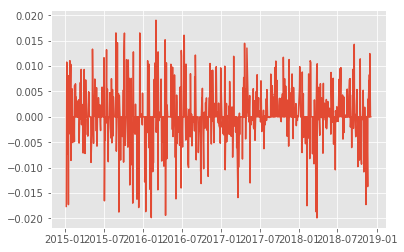

In [17]:
# resultsをプロット
import matplotlib.pyplot as plt 
import matplotlib

# ちょっとおしゃれスタイル
# その他スタイルはこちら
# matplotlibのstyleを変える - Qiita https://qiita.com/eriksoon/items/b93030ba4dc686ecfbba
plt.style.use('ggplot')

%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_test["results"])
plt.show()


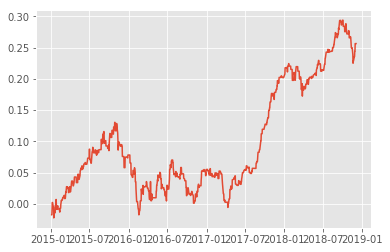

In [18]:
# 毎日の結果を足し合わせていってプロット
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(df_test["results"].cumsum())
plt.show()


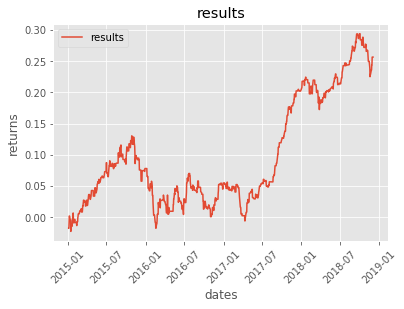

In [19]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(df_test["results"].cumsum(), )

# タイトル、軸ラベル設定
ax.set_title("results")
ax.set_xlabel("dates")
ax.set_ylabel("returns")

# 凡例を表示する
ax.legend()

# xラベルを45度回転
plt.setp(ax.get_xticklabels(), rotation=45)

plt.show()



#### 日本語を使う

1. 
[pip install して import するだけで matplotlib を日本語表示対応させる - Qiita ](https://qiita.com/uehara1414/items/6286590d2e1ffbf68f6c) に従って

`!pip install japanize-matplotlib` して、

```python
import japanize_matplotlib  # <- これ

plt.plot([1, 2, 3, 4])
plt.xlabel('簡単なグラフ')
plt.show()
```

で問題ないなら、それでOKだと思いますが、私の環境では `TypeError: scandir: illegal type for path parameter` がでましたので、ご指南書に従って日本語化しました。

2. 

https://github.com/adobe-fonts/source-han-code-jp/archive/2.000R.zip  をダウンロードしてインストール


```
import os
from matplotlib import font_manager 

font_manager._rebuild()

if os.name == 'nt':
    font_dir = font_manager.win32FontDirectory()
else:
    # 各自設定
    font_dir = '/usr/share/fonts/source-han-code-jp-2.000R/OTF'
font_path = os.path.join(font_dir, 'SourceHanCodeJP-Regular.otf')
font = font_manager.FontProperties(fname=font_path, size=14)

plt.plot([1, 2, 3, 4])
plt.xlabel("簡単なグラフ", fontproperties=font)
plt.show()
``` 



### 練習問題1

1. [https://finance.yahoo.com/quote/SPY/history?p=SPY](https://finance.yahoo.com/quote/SPY/history?p=SPY) からデータダウンロードする。
2. ファイルをDataFrame化する。
3. オーバーナイトの収益をプロットする
4. 日中のHighとLowの差が2％以上だったら、Closeで買って、次の日のCloseで売る。その収益をプロットする。

---


## テクニカル分析

世の中にはたくさんのテクニカル分析が有ります。投資家に人気がある分析指標を使って simulation をしてみましょう。


1. トレンド系
    1. 移動平均
    1. ボリンジャーバンド
    1. HLバンド
1. オシレーター系
    1. RSI
    1. MACD
    1. モメンタム
        


### 移動平均

移動平均とは、時系列データにおいて、ある一定区間ごとの平均値を区間をずらしながら求めたものです。毎日のデータを見るよりも、株価の方向（流れ、大局、）をより見やすくする指標と言えます。

DataFrameのメソッドである `rolling` を使うと簡単に求められます。

+ [pandas.DataFrame.rolling](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html)
+ rolling(window, min_periods=None, center=False, win_type=None, on=None, axis=0, closed=None)
+ `window`: 行数を指定。これが区間になる。
+ 返り値は `rolling` オブジェクト。

In [20]:
df_test = df.copy()

# 5日移動平均
n = 5
df_test.rolling(n)

Rolling [window=5,center=False,axis=0]

In [21]:
# この rolling オブジェクトが持つメソッドを使って、ほしい計算結果を得る。
df_test.rolling(n).mean().head(10)

,close,open,high,low
datetime,,,,
2015-01-05,NaN,NaN,NaN,NaN
2015-01-06,NaN,NaN,NaN,NaN
2015-01-07,NaN,NaN,NaN,NaN
2015-01-08,NaN,NaN,NaN,NaN
2015-01-09,17108.412,17124.332,17242.650,17010.966
2015-01-13,17044.212,17053.372,17152.008,16932.776
2015-01-14,17026.766,17025.420,17137.080,16910.542
2015-01-15,17071.440,17038.358,17170.554,16920.134
2015-01-16,17010.852,16987.470,17094.680,16835.430


プロットして観察します。

株価と移動平均を重ねてプロットすると、なにか気がつくかもしれません。

すこし複雑な図を描く時は `matplotlib.pyplot` を使うと便利です。詳しくは、[PythonユーザのためのJupyter[実践]入門](https://www.amazon.co.jp/dp/4774192236)を買って勉強してください。

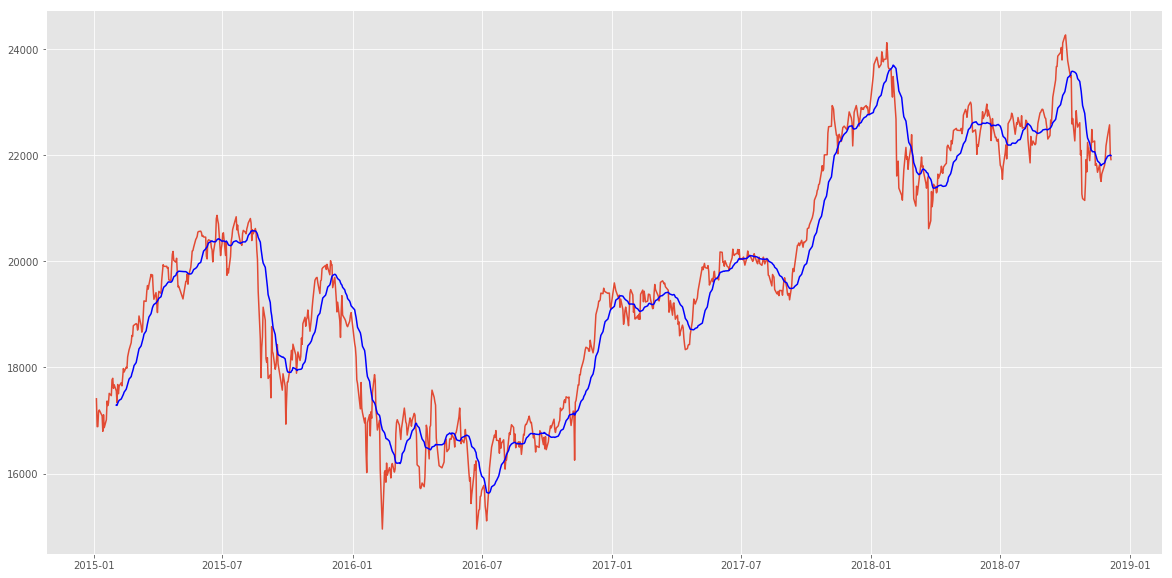

In [22]:
import matplotlib.pyplot as plt 

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)

ax1.plot(df_test["close"])
ax1.plot(df_test["close"].rolling(window=20).mean(), c='b')


さて、この描画から、どんなことが言えそうでしょうか？観察して考えてみましょう。

1. 過去n日と比べて今日の終値が大きく外れていれば、「平均の方にもどるんじゃない？」と予想して逆張り
1. 終値が移動平均より上にある間は買い持ちして、下にある間は売り持ちする。（順張り）

などが考えられます。1をやってみましょう。

まずは、移動平均と終値がどのくらい違いがあるのか見てみましょう。


In [23]:
df_test = df.copy()

n = 20

# ma : Moving Average の略。移動平均を表す時によく使われる。
df_test["ma"] = df_test["close"].rolling(window=n).mean() 
# close と ma しか使わないのでそれだけのDataFrameにする。
df_test = df_test[["close", "ma"]]

df_test["diff"] = df_test["close"] / df_test["ma"] - 1
df_test.head(30)


,close,ma,diff
datetime,,,
2015-01-05,17408.71,NaN,NaN
2015-01-06,16883.19,NaN,NaN
2015-01-07,16885.33,NaN,NaN
2015-01-08,17167.10,NaN,NaN
2015-01-09,17197.73,NaN,NaN
2015-01-13,17087.71,NaN,NaN
2015-01-14,16795.96,NaN,NaN
2015-01-15,17108.70,NaN,NaN
2015-01-16,16864.16,NaN,NaN


DataFrameのデータを簡単な統計値で確認したい時 `describe()` が便利です。

columns 毎に、個数、平均値、偏差、最大値、最小値、パーセンタイルを出してくれます。

In [24]:
df_test.describe()

,close,ma,diff
count,965.000000,946.000000,946.000000
mean,19643.427399,19644.754560,0.002522
std,2212.332882,2170.108551,0.027461
min,14952.020000,15628.831000,-0.120078
25%,17768.300000,17933.825500,-0.011000
50%,19620.910000,19605.356500,0.005244
75%,21676.510000,21699.081250,0.020858
max,24270.620000,23700.905000,0.065013


ここから察するに、`25%` タイルで `-1.1%` ずれているということなので、

close価格が maより-1.1％以下にある場合、ロングポジションを持つことにしてみましょう。



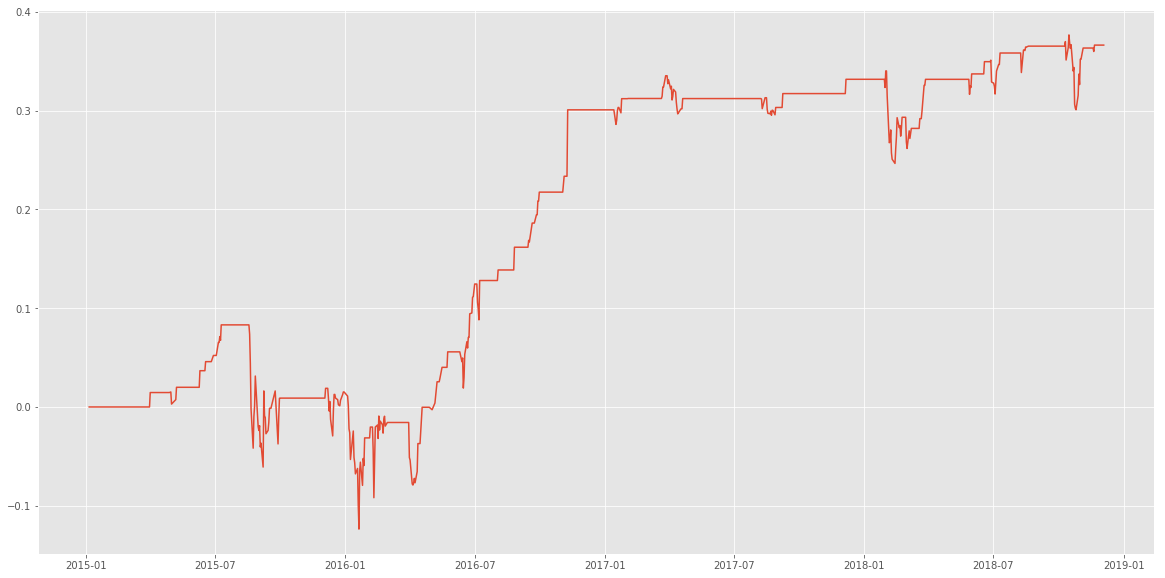

In [25]:
df_test["diff < -0.011"] = df_test["diff"] < -0.011
df_test["day return"] = df_test["close"].pct_change().shift(-1)
df_test["long position result"] = df_test["diff < -0.011"] * df_test["day return"]

fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.plot(df_test["long position result"].cumsum())


一時怖い時期はありますが、悪くないですね。

**練習問題**

では、`75%`タイルで `2.08％` ずれているので、

close価格が maより2.08％以上にある場合、ショートポジションを持つことにしてみましょう。

ショートポジション（売り持ち）なので、`df_test["day return"]` の計算をどのようにすればよいか注意してください

### ボリンジャーバンド

ボリンジャーバンドも、個人投資家に大変人気のある指標です。ボリバンとも呼ばれています。ボリンジャーとか、ボリバンとか呼ばれています。

移動平均だけでなく、その期間にどのくらい値がバラついたかも算出してバンドを形成し指標化したものです。

この図でいえば、<font color=red>BB_中心線（21）</font>というのが21日移動平均線、<font color=blue>BB_1σ</font>という線が、過去21日の値動きのバラツキの1σ区間です。

![](https://www.jibunbank.co.jp/products/foreign_deposit/chart/help/bollinger_band/img/img_01.png)
[ボリンジャーバンド | チャートの見方 | 為替レート＆チャート | じぶん銀行](https://www.jibunbank.co.jp/products/foreign_deposit/chart/help/bollinger_band/)より

そんな事言われてもわからんと思いますので、実際算出してみましょう。

ボリバンを出すのに便利なライブラリ `talib` を使います。

[mrjbq7/ta-lib: Python wrapper for TA-Lib (http://ta-lib.org/).](https://github.com/mrjbq7/ta-lib)


**メモ：**

talib を使うと、`TypeError: Argument 'real' has incorrect type (expected numpy.ndarray, got Series)` といったerrorに遭遇します。
最初の引数は real 型の配列でなくては行けません。pandas の Series は渡せません。



In [44]:
import talib as ta
import numpy as np

df_test = df.copy()

# BBAND は、価格配列、期間、バンド幅を渡す。
# 返り値は、上端、中央値、下端の価格配列を返します。

upper,middle,lower=ta.BBANDS(df_test["close"].values, 
                             timeperiod=21,
                             nbdevup=2, 
                             nbdevdn=2)

df_bb = pd.DataFrame({"upper":upper, "middle":middle, "lower":lower, "close":df_test["close"].values.astype(np.double)}, index = df_test.index)

df_bb.head(30)

,close,lower,middle,upper
datetime,,,,
2015-01-05,17408.71,NaN,NaN,NaN
2015-01-06,16883.19,NaN,NaN,NaN
2015-01-07,16885.33,NaN,NaN,NaN
2015-01-08,17167.10,NaN,NaN,NaN
2015-01-09,17197.73,NaN,NaN,NaN
2015-01-13,17087.71,NaN,NaN,NaN
2015-01-14,16795.96,NaN,NaN,NaN
2015-01-15,17108.70,NaN,NaN,NaN
2015-01-16,16864.16,NaN,NaN,NaN


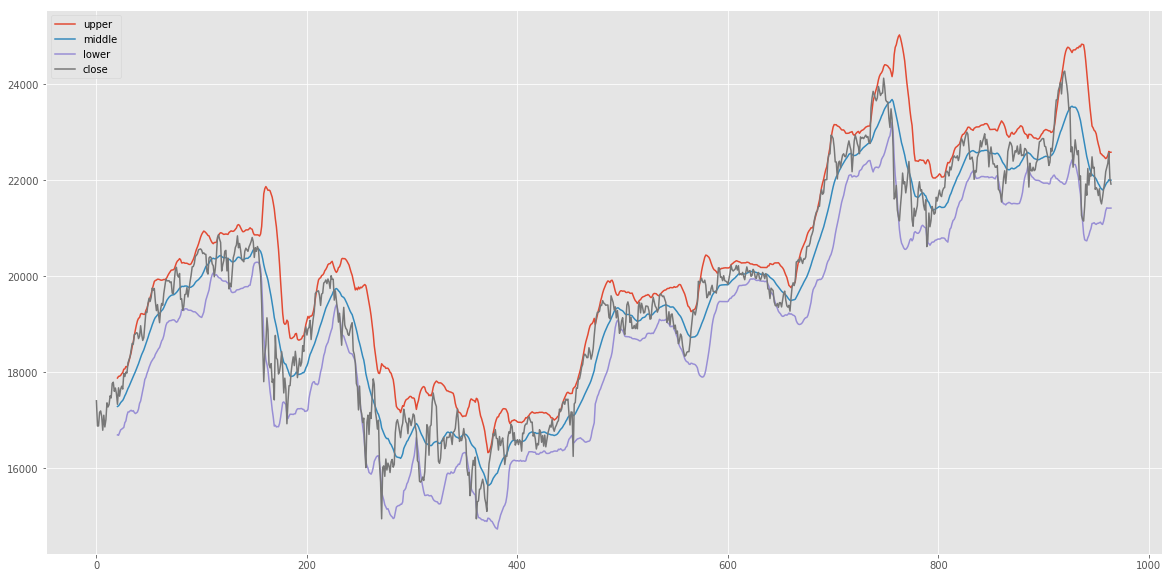

In [27]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

ax.plot(upper,label="upper")
ax.plot(middle,label="middle")
ax.plot(lower,label="lower")
ax.plot(df_bb["close"].values.astype(np.double), label="close")

# 凡例を表示する
ax.legend()


では観察しましょう。

両端（`upper`と`lower`)に `close` がタッチしたら反転しているようにも見えますね。

たとえば、`close` と `lower` を超えたら、その後急に上がり戻っているように見える箇所があります。

なので、`close` と `lower` の関係と、`close` の値動きの関係を散布図で観察してみましょう。


In [28]:
# lower と close の比率を確認（-1は0を基点にしたいので）
df_bb["close / lower"] = df_bb["close"] / df_bb["lower"] - 1 

# 一日後の収益率と二日後の収益率を取得
df_bb["1day return"] = df_bb["close"].pct_change(1).shift(-1)
df_bb["2day return"] = df_bb["close"].pct_change(2).shift(-2)
df_bb["3day return"] = df_bb["close"].pct_change(3).shift(-3)

df_bb.head()



,close,lower,middle,upper,close / lower,1day return,2day return,3day return
datetime,,,,,,,,
2015-01-05,17408.71,NaN,NaN,NaN,NaN,-0.030187,-0.030064,-0.013879
2015-01-06,16883.19,NaN,NaN,NaN,NaN,0.000127,0.016816,0.018630
2015-01-07,16885.33,NaN,NaN,NaN,NaN,0.016687,0.018501,0.011986
2015-01-08,17167.10,NaN,NaN,NaN,NaN,0.001784,-0.004625,-0.021619
2015-01-09,17197.73,NaN,NaN,NaN,NaN,-0.006397,-0.023362,-0.005177


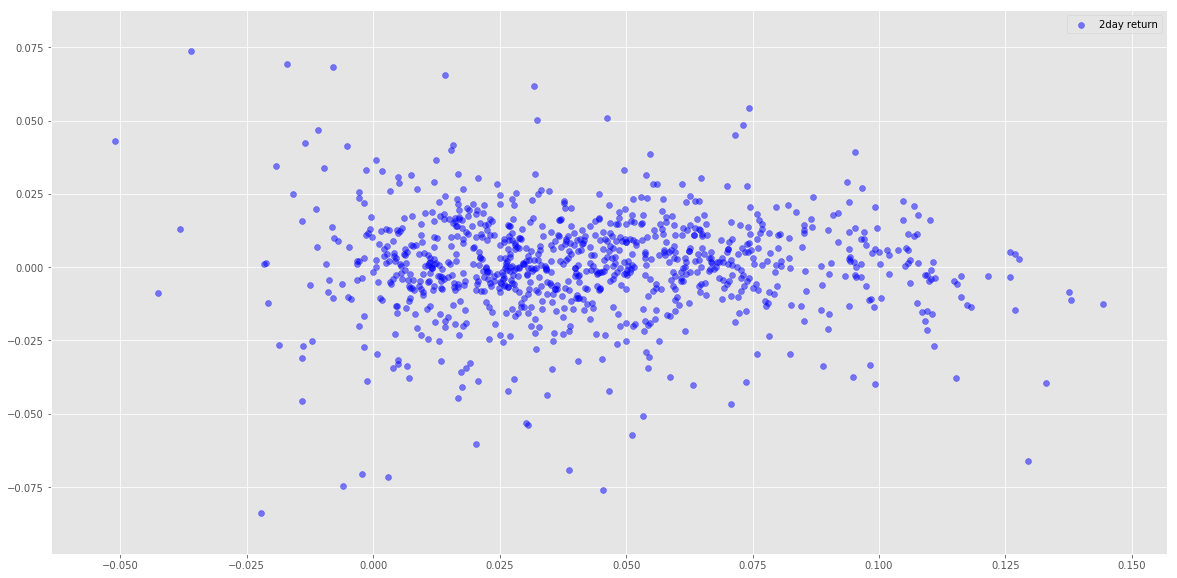

In [29]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

#ax.scatter(x=df_bb["close / lower"], y=df_bb["1day return"], alpha=0.5)
ax.scatter(x=df_bb["close / lower"], y=df_bb["2day return"], alpha=0.5, c='blue')
#ax.scatter(x=df_bb["close / lower"], y=df_bb["3day return"], alpha=0.5, c='green')

ax.legend()

そうすると、
+ `close/lower - 1` が -0.025以下、（closeがlowerよりも2.5％下にある）→2日後ポジティブリターンになっている場合が多い
+ `close/lower - 1` が 0.10以上、（closeがlowerよりも10％以上上にある）→2日後はネガティブリターンになっている場合が多い


In [30]:
results = (df_bb["close / lower"] < -0.025) * df_bb["2day return"] + \
          (df_bb["close / lower"] > 0.10) * df_bb["2day return"] * - 1
results.sum()

0.35499126085079646

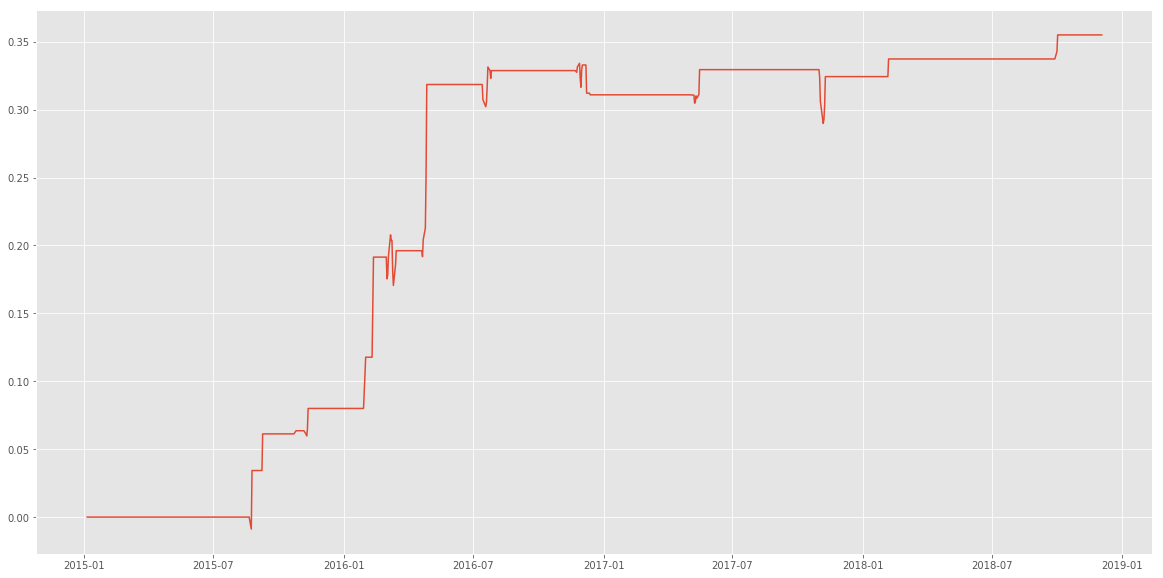

In [31]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(results.cumsum())

**練習問題**

1. `upper` と`close`の関係を見るとどうでしょうか？
1. バンド幅を1に変えて観察するとどうでしょうか？
1. 期間を21日ではなく、他の日付にしたらどうでしょうか？




### モメンタム

モメンタムとは、ｎ日前の価格との変化率を見る指標です。

使い方によって、オシレータ系にもトレンド系にもなる指標です。

今回はオシレータ系の使い方をしたいと思います。参考にしたサイトはこちら。

[モメンタムの見方・使い方| 株の達人](https://www.sevendata.co.jp/shihyou/technical/momentum.html#01)

このサイトによると、モメンタムの使い方は、
**相場が上昇している時の勢いが弱くなってきているのか、また相場が下降している時の勢いが強くなってきているのかを捉える先行指標**という事で、これまでのように売買のタイミングシグナル見つけるというよりは、現在は上げ相場なのか、下げ相場なのかを見るという事に使えそうです。

よって、その雰囲気を数値で表現して行きたいと思います。

まずは描画して雰囲気を掴みましょう。


                                             
                                                        

In [32]:
df_test = df.copy()

# n日前と現在の価格を比べる
n = 5 
df_test["past close"] = df_test["close"].shift(n) 
df_test["mom"] = df_test["close"] / df_test["past close"] - 1 
# pct_change()でも同じ
#df_test["mom"] = df_test["close"].pct_change(n)

df_test.head(10)


,close,open,high,low,past close,mom
datetime,,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,NaN,NaN
2015-01-07,16885.33,16808.26,16974.61,16808.26,NaN,NaN
2015-01-08,17167.10,17067.40,17243.71,17016.09,NaN,NaN
2015-01-09,17197.73,17318.74,17342.65,17129.53,NaN,NaN
2015-01-13,17087.71,16970.88,17087.71,16828.27,17408.71,-0.018439
2015-01-14,16795.96,16961.82,17036.72,16770.56,16883.19,-0.005167
2015-01-15,17108.70,16872.95,17141.98,16856.22,16885.33,0.013229
2015-01-16,16864.16,16812.96,16864.34,16592.57,17167.10,-0.017647


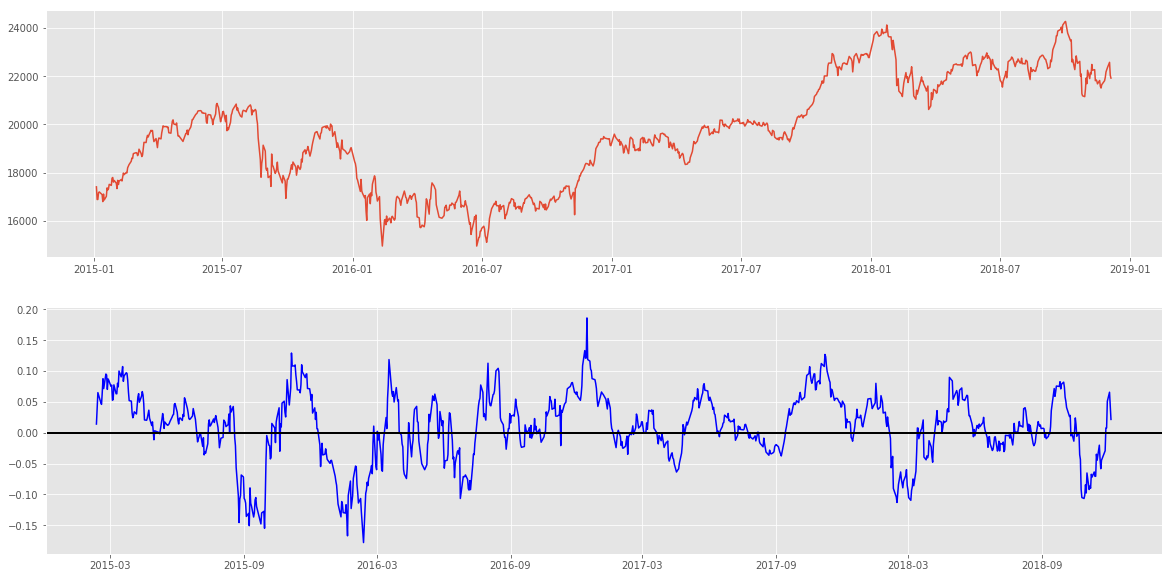

In [33]:
df_test = df.copy()

n = 25 
df_test["past close"] = df_test["close"].shift(n) 
df_test["mom"] = df_test["close"] / df_test["past close"] - 1 

fig = plt.figure(figsize=(20,10))
# add_subplot(総行数,総列数,番号)
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(df_test["close"])
ax2.plot(df_test["mom"], c = 'blue')
ax2.axhline(0, color='black', lw=2)


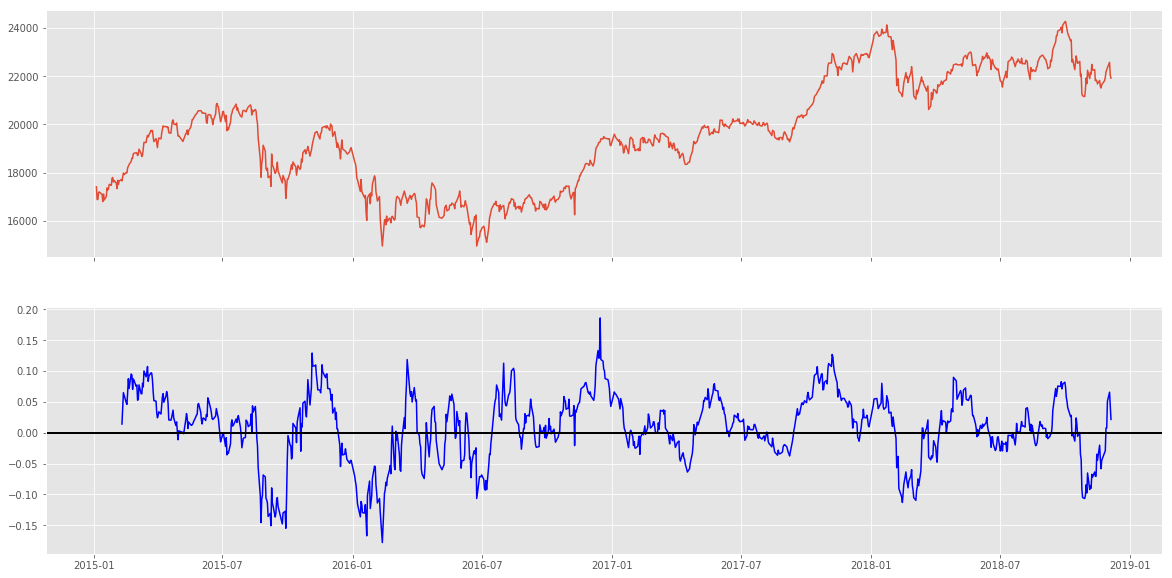

In [34]:
# ｘ軸がずれていて確認しづらい。subplots 関数を使う
fig, axes = plt.subplots(2,1, figsize=(20,10), sharex=True)
ax1, ax2 = axes
ax1.plot(df_test["close"])
ax2.plot(df_test["mom"], c = 'blue')
ax2.axhline(0, color='black', lw=2)

では単純にモメンタムが0以上だったら買い持ち、0以下だったら売り持ちする simulation をしてみましょう。

1. 将来収益率 `df_test["return"]`  を出す
1. `df_test["long position"]` フラグを作る
1. `df_test["short position"]` フラグを作る
1. `df_test["return"]` とフラグを掛け算
1. 足し合わせて積算して描画

売り持ちの時の`df_test["return"]` に注意しましょう。



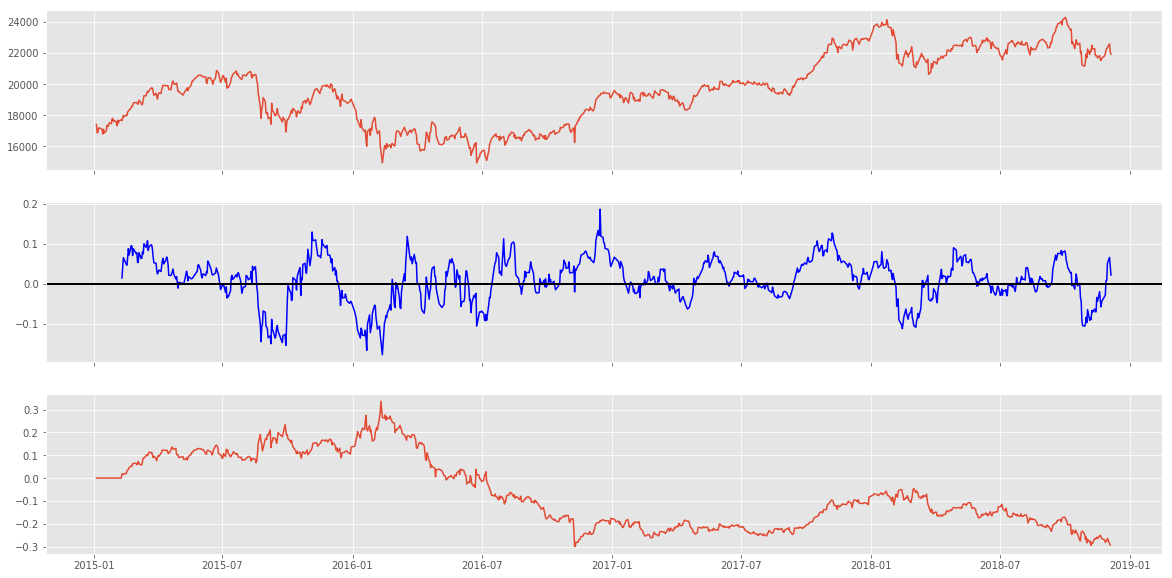

In [35]:

df_test["return"] = df_test["close"].pct_change().shift(-1)
df_test["long position"] = df_test["mom"] > 0 
df_test["short position"] = df_test["mom"] < 0 

results = df_test["return"] * df_test["long position"] +  df_test["return"] * -1 * df_test["short position"]

fig, axes = plt.subplots(3,1, figsize=(20,10), sharex=True)
ax1, ax2, ax3 = axes
ax1.plot(df_test["close"])
ax2.plot(df_test["mom"], c = 'blue')
ax2.axhline(0, color='black', lw=2)
ax3.plot(results.cumsum())



### HLバンド

![](https://fx-quicknavi.com/images/chart/hlbands2.png)
 [HLバンドの見方・使い方【テクニカル指標・トレンド系】](https://fx-quicknavi.com/chart/hlbands.html)より

+ H(High)バンド - 過去n日間の高値を結んだ線
+ L(Low)バンド - 過去n日間の安値を結んだ線
+ M(Middle)バンド - HバンドとLバンドの平均線

Hバンド・Lバンドをブレイクしたときに売買シグナルと判断をするみたいで、**Hバンドを上抜けたら買いサイン、Lバンドを下抜けたら売りサイン**、という使い方のようです．

まずは見てみましょう．


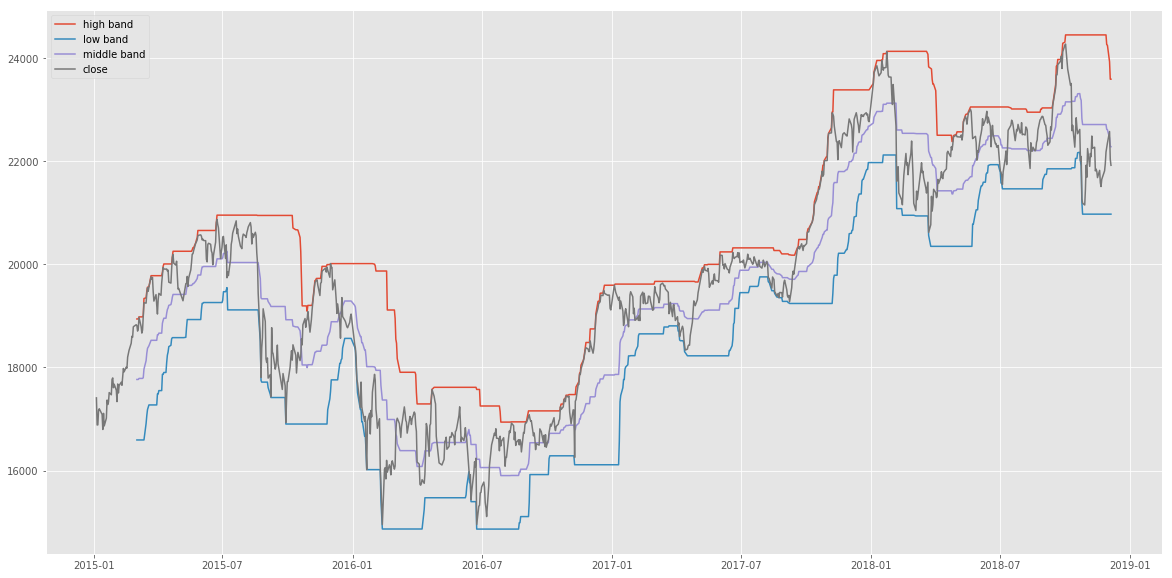

In [36]:
df_test = df.copy()

# 過去何日間のバンドを作るか
n = 40
m = 40
df_test["high band"] = df_test["high"].rolling(window=n).max()
df_test["low band"] = df_test["low"].rolling(window=m).min()
df_test["middle band"] = (df_test["low band"] + df_test["high band"]) / 2

fig, axes = plt.subplots(1,1, figsize=(20,10), )
axes.plot(df_test["high band"])
axes.plot(df_test["low band"])
axes.plot(df_test["middle band"])
axes.plot(df_test["close"])
axes.legend()


HLバンドを使った戦術もグーグル先生がたくさん教えてくれるのですが，
とりあえず自分たちで観察してみましょう．

**high band が高値を更新している間，ロングポジション**を持っていれば，儲かりそうな気がします．

それでやってみましょう．



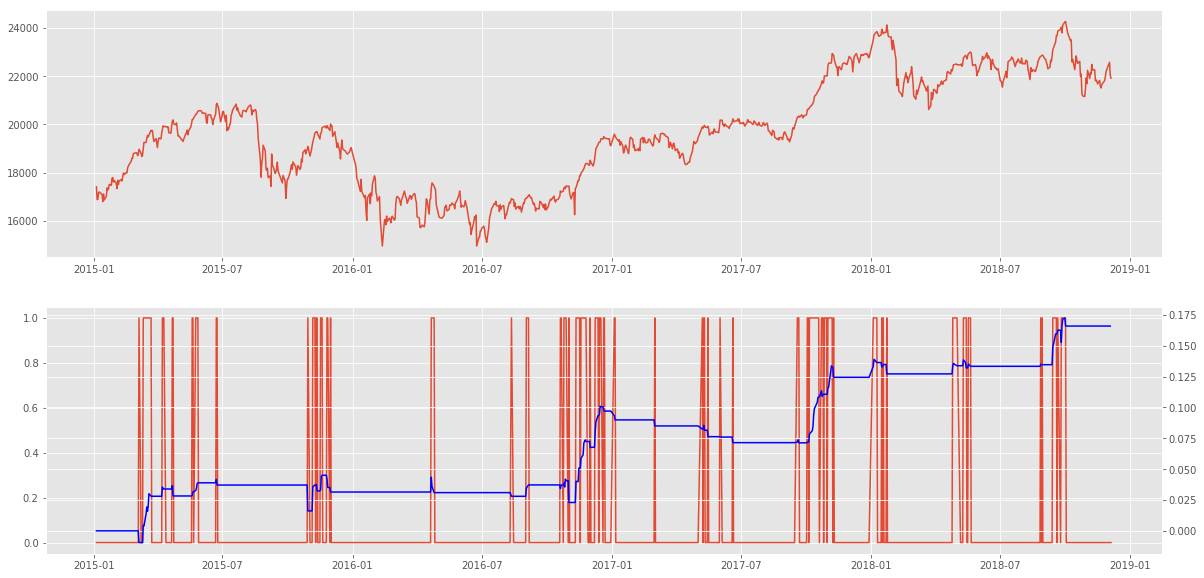

In [37]:
# 収益率を出す
df_test["return"] = df_test["close"].pct_change().shift(-1) 

# [高値を更新している間]を[high band 値が昨日の値よりも高い日にフラグを立てる] という戦略に読み替える
df_test["higher than yesterday"] = df_test["high band"] > df_test["high band"].shift(1)

fig, axes = plt.subplots(2,1, figsize=(20,10), )
ax1, ax2 = axes

# 日々の値動き
ax1.plot(df_test["close"])
# high band が前日よりも高い時のフラグを描画
ax2.plot(df_test["higher than yesterday"])

# 収益をsimulation
ax3 = ax2.twinx()
ax3.plot((df_test["higher than yesterday"] * df_test["return"]).cumsum(), c='blue')


### RSI 

RSIはオシレータ系で最も有名な指標かもしれません．計算式も簡単で

\begin{equation*}
RSI = \frac{過去ｎ日間で上昇した値幅}{過去ｎ日間で上昇した値幅+過去ｎ日間で下落した値幅} \times 100　\\
\end{equation*}

使い方は、RSIが一定以下であれば売られすぎ、一定以上なら売られすぎ、という判断をして**逆張り**するようです。

例えば、RSIが30以下の状態は売られすぎ、70以上は買われすぎ、という使い方です。

![](https://www.sevendata.co.jp/melmag/wp-content/uploads/2014/02/20140220.gif)
[【動画解説】５分でわかる！RSIの使い方！ | 株の達人活用ブログ～実践的なテクニックを解説～](https://www.sevendata.co.jp/melmag/archives/1288)より


では、RSIもtalibにありますので，使いましょう．

```
    RSI(real[, timeperiod=?])
    real: 価格配列
    timeperiod: 計算期間。デフォルト14
    
    返り値：RSI配列
```        


In [54]:
df_test = df.copy()
df_test["rsi"] = ta.RSI(df_test["close"].values, timeperiod=21)
df_test.head(30)


,close,open,high,low,rsi
datetime,,,,,
2015-01-05,17408.71,17325.68,17540.92,17219.22,NaN
2015-01-06,16883.19,17101.58,17111.36,16881.73,NaN
2015-01-07,16885.33,16808.26,16974.61,16808.26,NaN
2015-01-08,17167.10,17067.40,17243.71,17016.09,NaN
2015-01-09,17197.73,17318.74,17342.65,17129.53,NaN
2015-01-13,17087.71,16970.88,17087.71,16828.27,NaN
2015-01-14,16795.96,16961.82,17036.72,16770.56,NaN
2015-01-15,17108.70,16872.95,17141.98,16856.22,NaN
2015-01-16,16864.16,16812.96,16864.34,16592.57,NaN


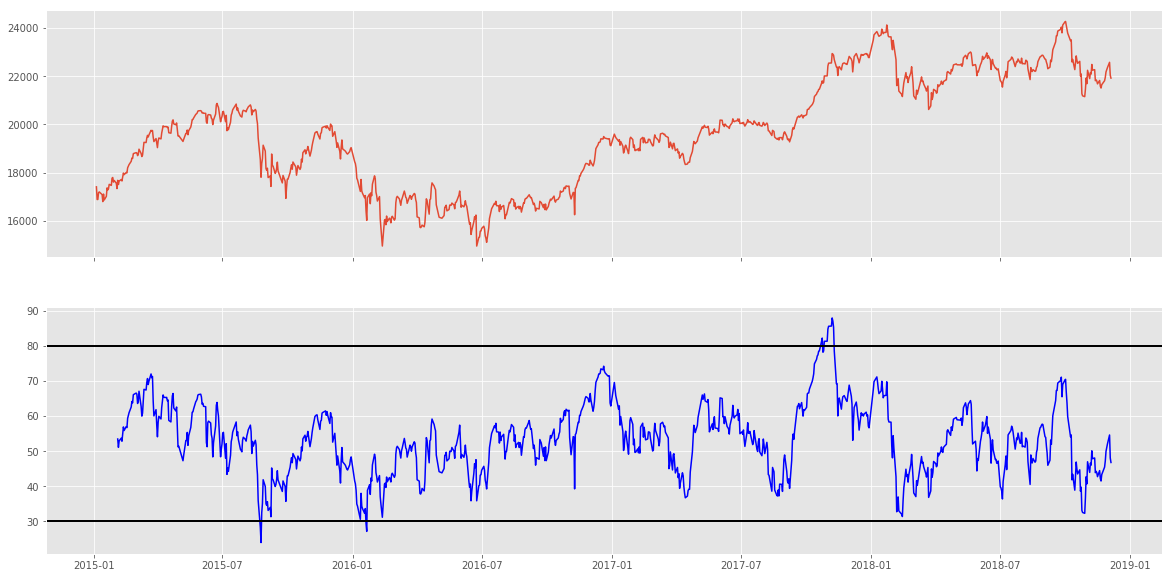

In [55]:
fig, axes = plt.subplots(2,1,figsize=(20,10), sharex=True)
ax1, ax2 = axes 

ax1.plot(df_test["close"])
ax2.plot(df_test["rsi"], c="blue")
ax2.axhline(30, color='black', lw=2)
ax2.axhline(80, color='black', lw=2)


では観察してみましょう。現在、RSIを期間21日で計算して、30を売られすぎ、70を買われすぎさ水準とみなして描画したのですが、どうでしょう？
期間や水準を変えて、多少納得の行く感じにしてみましょう。

こういう時、パラメータを変えて一つずつ見ていくのは面倒です。一度に結果を描画して比べたいですよね。

複数のグラフを描画する方法はいくつかありますが、シンプルな方法を一つご紹介します。


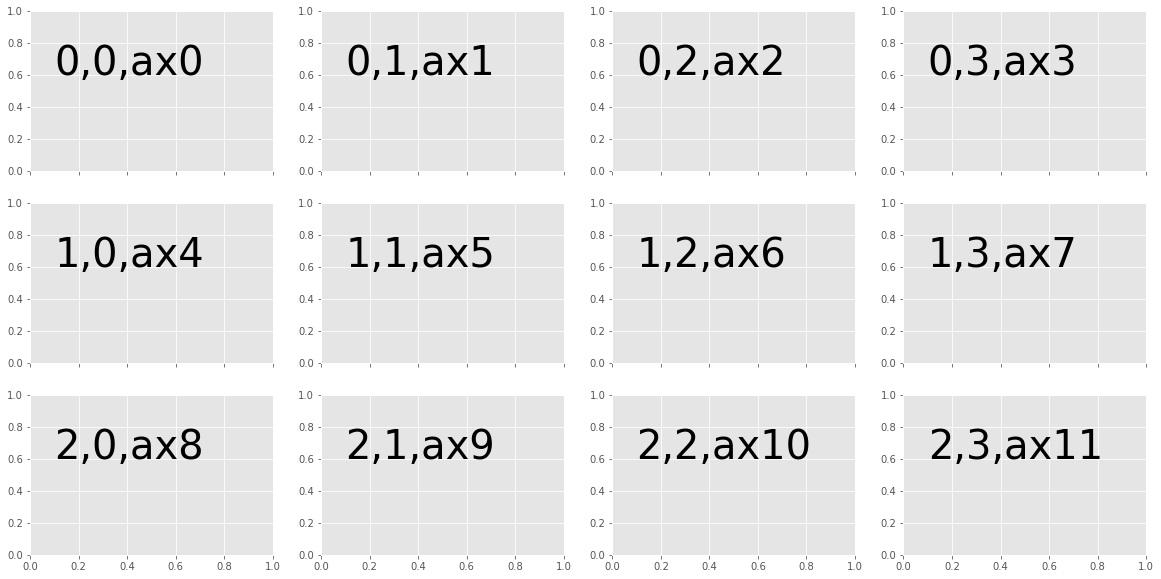

In [65]:
x = 3 # 縦の枚数
y = 4 # 横の枚数
a = 0 # 必須ではないが、何枚目かを確認するためのパラメタ

fig, axes = plt.subplots(x,y,figsize=(20,10), sharex=True)

# for を入れ子にしたくない人はリスト内包記を使うといいです。
for i in range(x):
    for t in range(y):
        text = "{},{},ax{}".format(i,t,a)
        axes[i,t].text(0.1, 0.6, text, size=40)
        a += 1


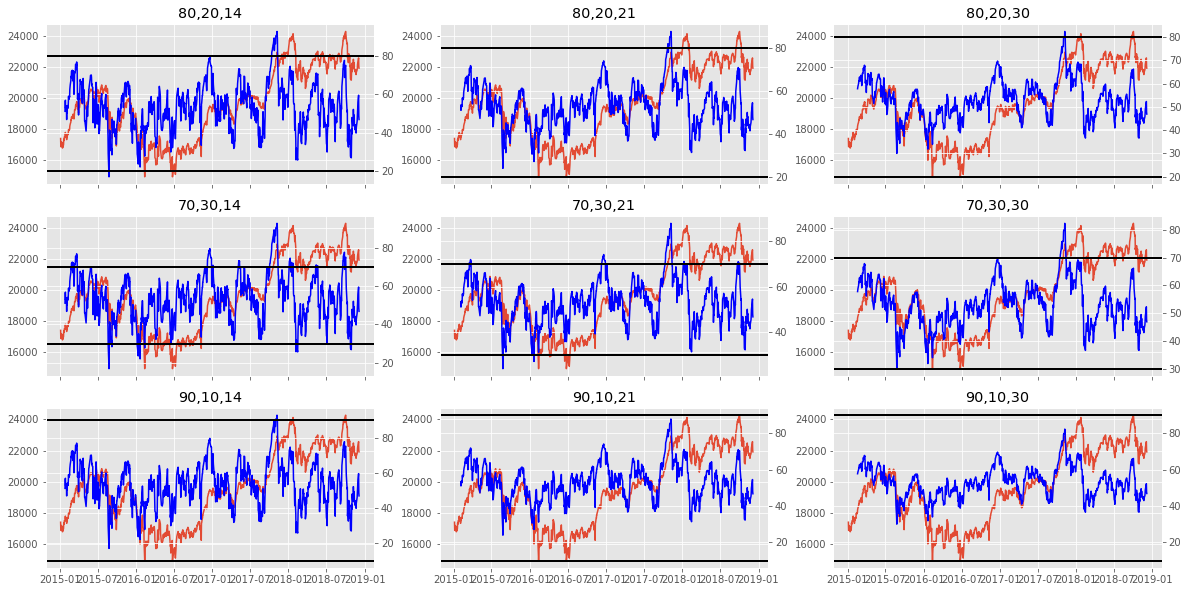

In [77]:
rsi_list = [(80,20), (70,30), (90,10)]
periods = [14,21,30,]
x = len(rsi_list)
y = len(periods)

fig, axes = plt.subplots(x,y,figsize=(20,10), sharex=True)

# for を入れ子にしたくない人はリスト内包記を使うといいです。

for i,rsi in enumerate(rsi_list):
    for t, period in enumerate(periods):
        upper, lower = rsi

        title = "{},{},{}".format(upper, lower, period)
        df_test["rsi"] = ta.RSI(df_test["close"].values, timeperiod=period)
        
        axes[i,t].plot(df_test["close"])
        axes[i,t].set_title(title)
        ax1 = axes[i,t].twinx()
        ax1.plot(df_test["rsi"], c = 'blue', )
        ax1.axhline(upper, color='black', lw=2)
        ax1.axhline(lower, color='black', lw=2)
        

うん、どれも良さそうに見えないですね。。。パラメータを変えて良さそうなのが見つかったら教えてください。複数プロット表示をしたので良しとして次言ってみましょうｗ


## MACD

MACDは，期間の長い指数移動平均と短い指数移動平均の差を使って売買シグナルを出す指標です．

移動平均はすでに説明しましたが、今回使うのは**指数**移動平均。移動平均に指数関数的に重み付けした移動平均です。説明は難しいので詳しくは[wikipedia](https://ja.wikipedia.org/wiki/%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87#%E6%8C%87%E6%95%B0%E7%A7%BB%E5%8B%95%E5%B9%B3%E5%9D%87)先生にお尋ねください。


MACDを株式分析に使う時はこのような計算をして、

```
MACD = SlowEMA - FastEMA
MACDSignal = SMA(MACD) 

ただし
　SlowEMA : 期間の長い指数移動平均
　FastEMA : 期間の短い指数移動平均
　SMA：移動平均関数
```

`MACD`が`MACDSignal`を上抜いた時，ロングポジションを取るようです。下図を例に説明するとゴールデンクロスと呼ばれるところで買い持ちし、デッドクロスで売り持ちするようです。

![](https://www.nomura.co.jp/learn/chart/images/chart_08_img04_2.gif)
[野村證券 | 株・FXに今すぐ活かせる チャートの読み方・使い方 - トレンドフォロー系指標「移動平均」と「MACD」 -](https://www.nomura.co.jp/learn/chart/page8.html)より

まずは、`MACD`と`MACDSignal`を描画してみましょう。MACD もtalibに定義されています。


```
MACD(real[, fastperiod=?, slowperiod=?, signalperiod=?])
    
    Inputs:
        real: 関数配列
    Parameters:
        fastperiod: 短い指数移動平均の期間　デフォルト 12　
        slowperiod: 長い指数移動平均の期間　デフォルト 26　
        signalperiod: 移動平均の期間　デフォルト 9　
    Outputs:　
        macd
        macdsignal
        macdhist
```


In [81]:
df_test = df.copy()

macd, macdsignal, macdhist = ta.MACD(df_test["cdf_nissanlose"].values) # 期間のパラメータはデフォルト値を使う
df_test["macd"] = macd
df_test["macdsignal"] = macdsignal

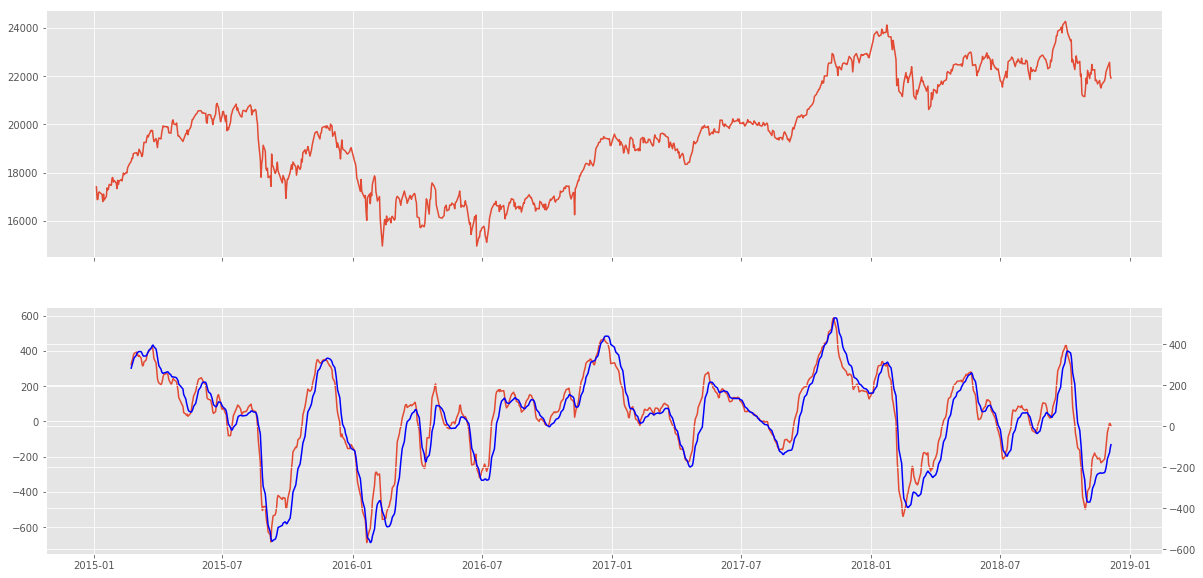

In [87]:
fig, axes = plt.subplots(2,1, figsize=(20,10), sharex=True)
ax1, ax2 = axes 
ax1.plot(df_test["close"])
ax2.plot(df_test["macd"] )
ax3 = ax2.twinx()
ax3.plot(df_test["macdsignal"], c='blue')


観察してみましょう。

こうやって見てみると、単に`macd`が`macdsignal`をうわ抜いた時というより、上にある間は上昇トレンド、下にある間は下降トレンドのように見えます。どうでしょう？

その発想で simulation を書いてみましょう。

わかりやすくするためにこのような条件にしてみます。

「`macd`が`macdsignal`を5日以上上回っていたら買い持ちし続ける。」

としてみましょう。

simulation を書くためには、

1. `macd`が`macdsignal`より上にあるかどうかのフラグ `df_test["flag"]` を作成
1. `df_test["flag"]` の移動足し算を `df_test["moving sum"]` を作成
1. `df_test["moving sum"]`が5であれば過去5日間すべて `macd`が`macdsignal`より上にあることになるので、`df_test["moving sum"]`が5であるかどうかのフラグ `df_test["long"]` を作成
1. あとはいつも通り、将来収益率を`df_test["long"]`に掛け算してプロットする。

やってみよう！

答えは下のセルに隠してあります。



In [106]:

# df_test["flag"] = df_test["macd"] > df_test["macdsignal"] 
# df_test["moving sum"] = df_test["flag"].rolling(window=5).sum() 
# df_test["long"] = df_test["moving sum"] == 5
# df_test["return"] = df_test["close"].pct_change().shift(-1)

# fig, axes = plt.subplots(1,1,figsize=(20,10))
# axes.plot((df_test["return"] * df_test["long"]).cumsum())


## 練習問題

（**答えは別ノートブック [テクニカル分析練習問題答え]にまとめています。**）

1. https://kabuoji3.com/stock/ から好きな会社の株価を4つダウンロードしてください。（2018年だけでいいです）
1. csv を dataframe にしてください。その時DateTime型や数値型になっている事をキチンと確認してください。
1. 各銘柄の[終値調整値]をプロットしてください。
1. 各銘柄の[終値調整値]の移動平均をプロットしてください。
1. お好きな分析指標を使ってsimulation をしてください。ただしHLバンドをする場合は、高値と安値は、終値調整値で調整してください。



### 終値調整値とは、

日付|始値|高値|安値|終値|出来高|終値調整値
---|---:|---:|---:|---:|---:|---:
2009-01-05|37150|37450|36550|37000|48382|370
2009-01-06|37300|40300|37200|38400|222607|384
2009-01-07|38400|39900|35100|36050|225114|360.5
2009-01-08|36200|36300|33500|33950|203189|339.5
2009-01-09|34750|34850|33900|34100|132310|341
2009-01-13|34050|34050|33050|33450|70888|334.5

これやヤフーの2009年の株価です。ヤフーは2009年以降何度か株式分割ををしています。その分割を調整して、現在の価格と比較出来るようにしたのが「終値調整値」です。

通常、終値調整値は終値でしか示されていない事が多いです。ですので、始値、高値、安値を検証する場合は、終値調整値から計算して調整する必要があります。

計算方法は、`終値調整値 / 終値` で係数を作り、それを各値に掛ければよいです。例：

日付|始値|高値|安値|終値|出来高|終値調整値|係数|調整後始値|調整後高値|調整後安値
---|---:|---:|---:|---:|---:|---:|---:|---:|---:|---:
2009-01-05|37150|37450|36550|37000|48382|370|0.01|371.5|374.5|365.5
2009-01-06|37300|40300|37200|38400|222607|384|0.01|373|403|372
2009-01-07|38400|39900|35100|36050|225114|360.5|0.01|384|399|351
2009-01-08|36200|36300|33500|33950|203189|339.5|0.01|362|363|335
2009-01-09|34750|34850|33900|34100|132310|341|0.01|347.5|348.5|339
2009-01-13|34050|34050|33050|33450|70888|334.5|0.01|340.5|340.5|330.5




参照：
[Yahoo!ファイナンスヘルプ - 調整後終値とは](https://www.yahoo-help.jp/app/answers/detail/p/546/a_id/45316/~/%E8%AA%BF%E6%95%B4%E5%BE%8C%E7%B5%82%E5%80%A4%E3%81%A8%E3%81%AF)
